# Real-Time Microsoft Equity Pricing Simulation using Stochastic Models

## For this project, we will use Alphavantage API for the 100 most recent price data of US stocks. This Project will use Microsoft's stocks as a Demo.

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

symbol = 'MSFT'
interval = '60min'
api_key = 'LM57I8IVNNH7GJN2'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={api_key}&outputsize=compact'
r = requests.get(url)
data = r.json()

# Meta Data of the API

In [2]:
meta_data = data["Meta Data"]

keys = list(meta_data.keys())
values = list(meta_data.values())

for input in keys:
    index = keys.index(input)
    keys[index] = re.sub(r'^[\d.]+\s*', '',input)
    
meta_data = {keys[0]: keys[1:], values[0]: values[1:]}
meta_data = pd.DataFrame(meta_data)
meta_data

,Information,"Intraday (60min) open, high, low, close prices and volume"
0,Symbol,MSFT
1,Last Refreshed,2024-03-14 19:00:00
2,Interval,60min
3,Output Size,Compact
4,Time Zone,US/Eastern


# Data Pre-Processing

In [3]:
dataset = data[f"Time Series ({interval})"]
new_ds = {'date': [], 'open':[], 'high':[], 'low':[], 'close':[], 'volume':[]}

for date in dataset:
    new_ds['date'].append(date)
    for index, item in enumerate(new_ds):
        if index == 0 : continue
        new_ds[item].append(dataset[date][f'{index}. {item}'])

new_ds = pd.DataFrame(new_ds)

for column in new_ds.columns[1:]:
    new_ds[column] = new_ds[column].apply(lambda x: float(x.replace(',', '.')))

new_ds

,date,open,high,low,close,volume
0,2024-03-14 19:00:00,426.700,426.800,425.760,426.400,23477.0
1,2024-03-14 18:00:00,426.230,427.000,426.200,426.710,25785.0
2,2024-03-14 17:00:00,426.400,426.420,408.293,426.230,51644.0
3,2024-03-14 16:00:00,425.487,428.725,397.894,426.385,9069010.0
4,2024-03-14 15:00:00,425.730,426.391,422.630,425.490,5319850.0
...,...,...,...,...,...,...
95,2024-03-07 04:00:00,400.600,404.850,400.600,404.360,30663.0
96,2024-03-06 19:00:00,401.690,402.000,400.350,400.510,16581.0
97,2024-03-06 18:00:00,402.150,402.190,327.294,401.500,14290.0
98,2024-03-06 17:00:00,402.200,402.400,401.990,402.150,7235.0


# Exploratory Data Analysis

             open        high         low       close        volume
count  100.000000  100.000000  100.000000  100.000000  1.000000e+02
mean   410.869200  412.673850  406.383140  411.116940  1.491995e+06
std      6.884285    7.724428   14.412613    6.990684  2.017240e+06
min    400.600000  402.000000  324.850000  400.510000  2.903000e+03
25%    405.690000  406.732500  403.802500  405.720000  2.034075e+04
50%    408.360000  409.653500  406.890000  408.195000  4.183335e+05
75%    415.306250  416.562500  414.495000  415.425000  2.403285e+06
max    426.700000  440.380000  426.200000  426.710000  9.069010e+06


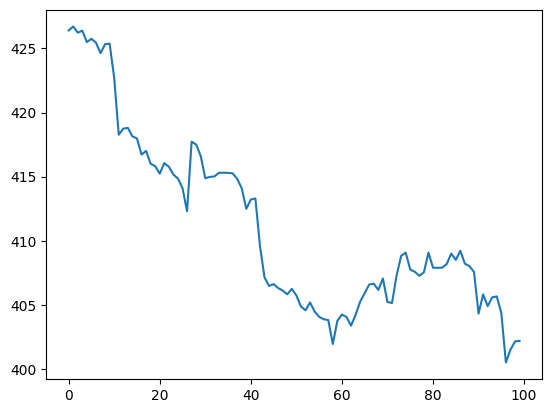

In [4]:
summary = new_ds.describe()
print(summary)

plt.plot(new_ds["close"])

# Making the Data Stationary by Calculating Returns

Text(0.5, 1.0, 'Returns')

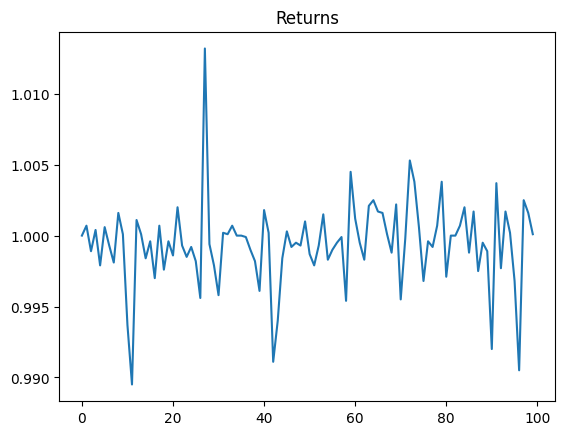

In [5]:
prev = new_ds["close"][0]
returns = [1]
for i in new_ds["close"][1:]:
    returns.append((1 + round((i-prev)/prev, 4)))
    prev = i

new_ds["returns"] = returns
plt.plot(new_ds["returns"])
plt.title("Returns")

# Estimating Drift & Volatility

In [6]:
drift = np.mean(np.log(new_ds["returns"]))
volatility = np.std(np.log((new_ds["returns"])))

print(f"Drift: {drift}")
print(f"Volatility: {volatility}")

Drift: -0.0005877322476258961
Volatility: 0.0030206749810973597


# Simple Random Walk Simulation

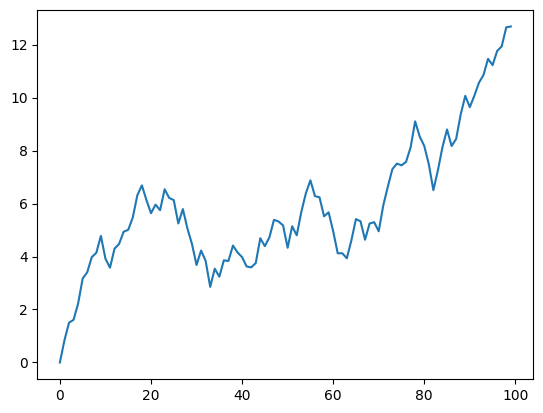

In [7]:
max = '500'
points = 100
url = f'https://www.random.org/integers/?num=1&min=0&max={max}&col=5&base=10&format=plain'
number = int(requests.get(url).text)

x_range = np.arange(0, points)
random_walk = np.random.default_rng(number)
values = 2 * random_walk.random(size=points) - 1

cumulative = [sum(values[0:x]) for x in range(len(values))]

plt.plot(x_range, cumulative)

# Building it up to the Geometric Brownian Motion

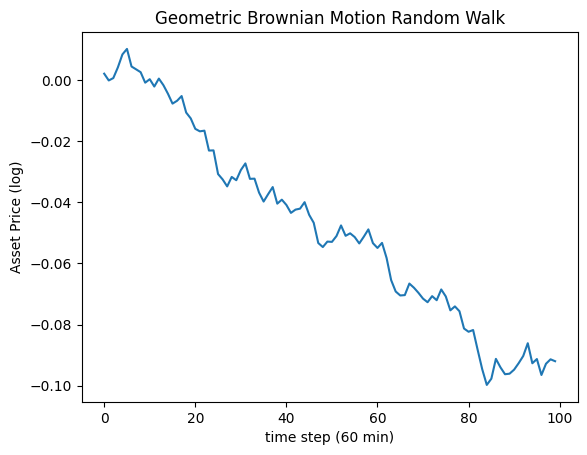

In [8]:
number2 = int(requests.get(url).text)
num_simulations = 1
num_steps = 100
dt = 1

def gbm_drift(mu, sigma, dt):
    return (mu - 0.5 * sigma ** 2) * dt

def gbm_vol(sigma, dt):
    return sigma * np.sqrt(dt)

np.random.seed(number2)

random_samples = np.random.normal(gbm_drift(drift, volatility, dt), gbm_vol(volatility, dt), size=(num_simulations, num_steps))
gbm_random_walk = np.cumsum(random_samples, axis=1)

plt.plot(gbm_random_walk.T)
plt.title('Geometric Brownian Motion Random Walk')
plt.xlabel('time step (60 min)')

plt.ylabel('Asset Price (log)')
plt.show()

## Model Evaluation

Mean Squared Error: 0.3246754081109418


Text(0.5, 1.0, 'Historical Data vs Random Simulation')

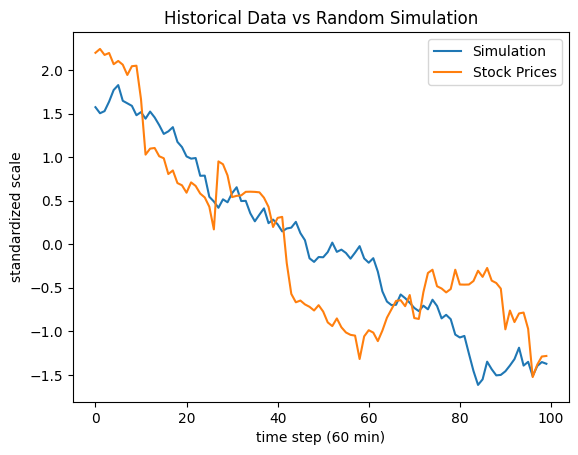

In [9]:
normalized_gbm = (gbm_random_walk.T - np.mean(gbm_random_walk.T)) / np.std(gbm_random_walk.T)
normalized_stock = (new_ds["close"] - np.mean(new_ds["close"])) / np.std(new_ds["close"])

mse = np.mean((np.squeeze(normalized_gbm) - normalized_stock)**2)
print(f"Mean Squared Error: {mse}")

plt.plot(normalized_gbm, label="Simulation")
plt.plot(normalized_stock, label='Stock Prices')
plt.xlabel('time step (60 min)')
plt.ylabel('standardized scale')
plt.legend()
plt.title('Historical Data vs Random Simulation')